## Automate: create, detect, write high_res blend 
started: Aug 18th 2020 <br>
edit: Oct 14 2020

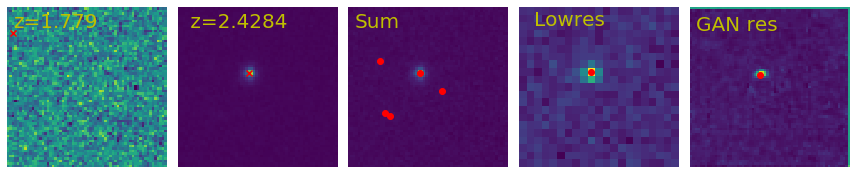

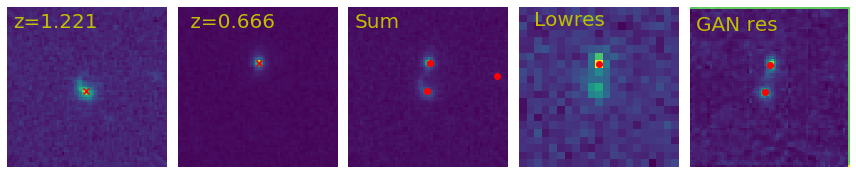

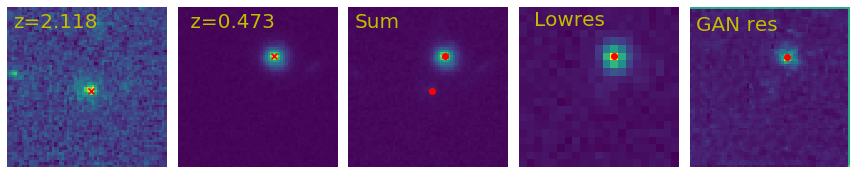

In [2]:
from galblend2 import *
%matplotlib inline 

hi,lo,gan,data = galblend2(gals=2,lim_hmag=24,plot_it=True)
hi,lo,gan,data = galblend2(gals=2,lim_hmag=24,plot_it=True)
hi,lo,gan,data = galblend2(gals=2,lim_hmag=24,plot_it=True)


In [4]:
import astropy.io.fits as fits
f = open('Coordinates_gan.txt','w+')
k=0
for i in range(5000):
    hi,lo,gan,data = galblend2(gals=2,lim_hmag=24,plot_it=False)
    x,y=str2coord(str(data[5][2]))
    xlo,ylo=str2coord(str(data[5][1]))
    if (len(x)==2) and (len(xlo)==1):
        fits.writeto('images/low_res_'+str(k)+'.fits',lo,overwrite=True)
        f.write(str(k)+'\t'+str(x[0])+'\t'+str(x[1])+'\t'+str(y[0])+'\t'+str(y[1])+'\t'+str(data[3][0])+'\t'+str(data[3][1])+'\t'+str(xlo[0])+'\t'+str(ylo[0])+'\n')
        k+=1
f.close()

1 of 1817
101 of 1817
201 of 1817
301 of 1817
     Number of calls to function has reached maxfev = 4500.
401 of 1817
501 of 1817
601 of 1817
701 of 1817
801 of 1817
901 of 1817
1001 of 1817
1101 of 1817
1201 of 1817
1301 of 1817
1401 of 1817
1501 of 1817
1601 of 1817
1701 of 1817
1801 of 1817
--Return--
None
> /Users/shemmati/Dropbox/kinematic_lensing/disks/Blending/photom.py(308)<module>()
    306     ax2.set_yscale('log')
    307     plt.savefig('flux_comparison.png')
--> 308     ipdb.set_trace()



ipdb>  a
ipdb>  
ipdb>  
ipdb>  exit


BdbQuit: 

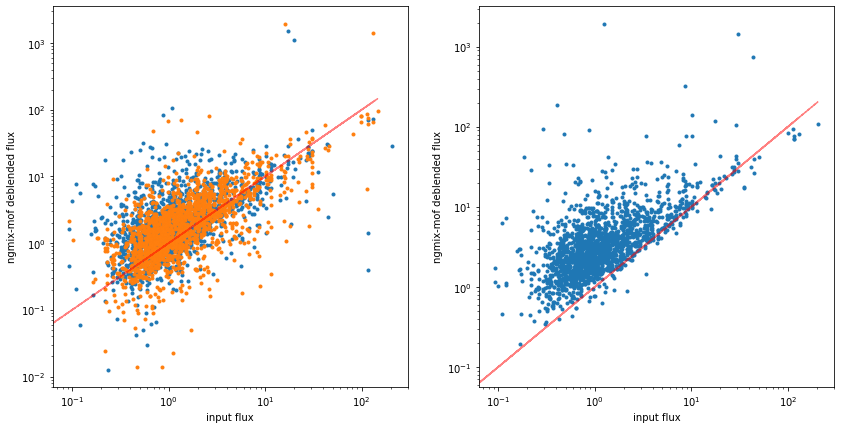

In [7]:
%run photom.py

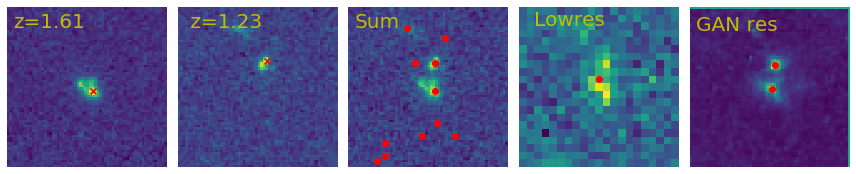

[0.7224956747275377, array(1.69744971), 0.3800000000000001, 8.26, 2, 1, 2]


In [26]:
a,galax,g,data = galblend2(gals=2,lim_hmag=25,plot_it=True)

x_low,y_low = str2coord(str(data[5][1]))
x_gan,y_gan = str2coord(str(data[5][2]))
x_hi,y_hi = str2coord(str(data[5][0]))
x,y = [data[0][0],data[0][1]],[data[1][0],data[1][1]]
numgan = MatchGan(x,y,x_gan,y_gan)
numhi = MatchGan(x,y,x_hi,y_hi)
numlow = MatchLow(x,y,x_low,y_low)
dis = 0.06*distance (data[0][0],data[0][1],data[1][0],data[1][1])
mag = magdis(data[3][0],data[3][1])
dz = np.abs(data[2][0]-data[2][1])
s = max(data[4][0],data[4][1])
print([dis,mag,dz,s,numhi,numlow,numgan])     



In [30]:
f = open('blend_data_new.txt','w+')
for i in range(5000):
    a,galax,g,data = galblend2(gals=2,lim_hmag=24,plot_it=False)
    f.write(str(data[0][0])+'\t'+str(data[0][1])+'\t'+str(data[1][0])+'\t'+str(data[1][1])+'\t'+str(data[2][0])
            +'\t'+str(data[2][1])+'\t'+str(data[3][0])+'\t'+str(data[3][1])
            +'\t'+str(data[4][0])+'\t'+str(data[4][1])+'\t'+str(data[5][0])+'\t'+str(data[5][1])
            +'\t'+str(data[5][2])+'\n')
f.close()

/Users/shemmati/Dropbox/kinematic_lensing/disks/Blending/galblend2.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gals =torch.tensor(gals, device="cpu").float()
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functio

In [31]:
import pandas as pd
data = pd.read_csv('blend_data_new.txt', sep="\t", header=None)
data.columns = ["x1","x2", "y1","y2", "z1","z2", "flux1","flux2","s1","s2","coord_hi","coord_low","coord_gan"]

data2=[]
for boz in range(len(data['x1'])):
    x_low,y_low = str2coord(data['coord_low'][boz])
    x_gan,y_gan = str2coord(data['coord_gan'][boz])
    x_hi,y_hi = str2coord(data['coord_hi'][boz])
    x,y = [data['x1'][boz],data['x2'][boz]],[data['y1'][boz],data['y2'][boz]]
    numgan = MatchGan(x,y,x_gan,y_gan)
    numhi = MatchGan(x,y,x_hi,y_hi)
    numlow = MatchLow(x,y,x_low,y_low)
    dis = 0.06*distance (data['x1'][boz],data['x2'][boz],data['y1'][boz],data['y2'][boz])
    mag = magdis(data['flux1'][boz],data['flux2'][boz])
    dz = np.abs(data['z1'][boz]-data['z2'][boz])
    if (0<data['flux1'][boz]<100)&(0<data['flux2'][boz]<100):
        data2.append([dis,data['flux1'][boz],data['flux2'][boz],data['z1'][boz],data['z2'][boz],data['s1'][boz],data['s2'][boz],numhi,numlow,numgan])                                 

df = pd.DataFrame(data2)
df.columns = ["distance", "flux1", "flux2", "z1", "z2", "s1", "s2","numhi" ,"numlow","numgan"]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars


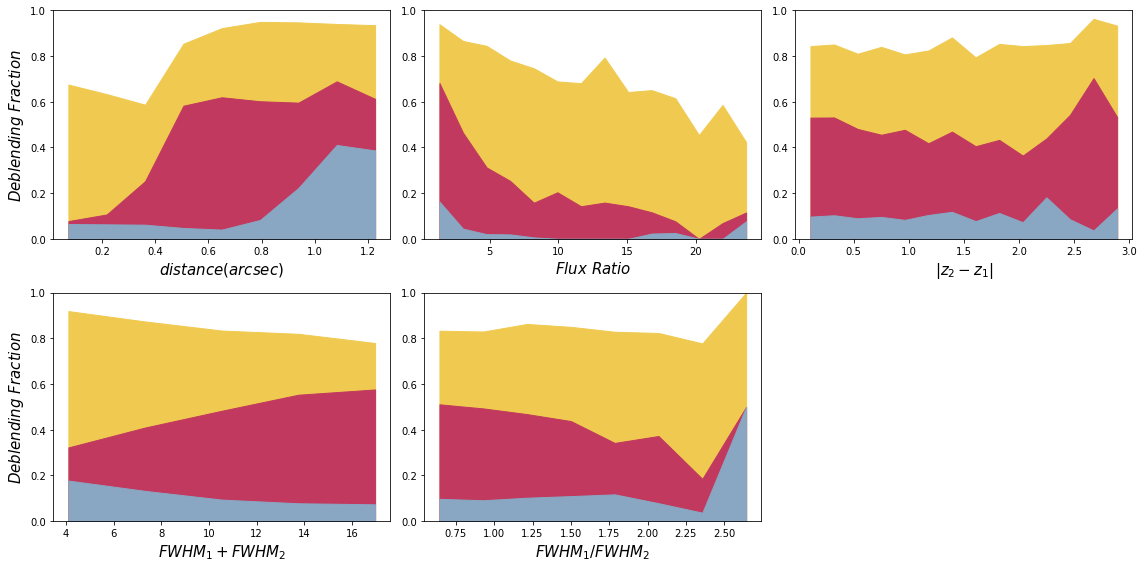

In [32]:
plt.figure(figsize=(16,8))

plt.subplot(2,3,1)
bins = np.linspace(0, 1.3, 10)
digitized = np.digitize(df['distance'], bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.xlabel(r'$distance (arcsec)$',fontsize=15)
plt.ylabel(r'$ Deblending\ Fraction$',fontsize=15)
plt.ylim([0,1])

plt.subplot(2,3,2)
bins = np.linspace(1, 25, 15)
fmax = np.maximum(np.array(df['flux1']),np.array(df['flux2']))
fmin = np.minimum(np.array(df['flux1']),np.array(df['flux2']))
flux_ratio=fmax/fmin
digitized = np.digitize(flux_ratio, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum((df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2)) for i in range(1, len(bins))]
bin_means_gan = [np.sum((df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2)) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.xlabel(r'$Flux\  Ratio$',fontsize=15)
#plt.legend(loc=1,fontsize=20)
plt.ylim([0,1])

plt.subplot(2,3,3)
bins = np.linspace(0., 3, 15)
dz = np.abs(df['z1']-df['z2'])
digitized = np.digitize(dz, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
#plt.legend(fontsize=15,loc=4)
plt.ylim([0,1])
plt.xlabel(r'$|z_{2}-z_{1}|$',fontsize=15)

plt.subplot(2,3,4)
bins = np.linspace(5, 50, 15)
sumsize = (df['s1']+df['s2'])
digitized = np.digitize(sumsize, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
#plt.legend(fontsize=15,loc=4)
plt.xlabel(r'$FWHM_{1}+FWHM_{2}$',fontsize=15)
plt.ylabel(r'$ Deblending\ Fraction$',fontsize=15)
plt.ylim([0,1])

plt.subplot(2,3,5)
bins = np.linspace(1, 5, 15)
smax = np.maximum(np.array(df['s1']),np.array(df['s2']))
smin = np.minimum(np.array(df['s1']),np.array(df['s2']))
ds=smax/smin
digitized = np.digitize(ds, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
#plt.legend(fontsize=15,loc=4)
plt.ylim([0,1])
plt.xlabel(r'$FWHM_{1}/FWHM_{2}$',fontsize=15)
plt.tight_layout()

plt.savefig('../plots/deblend_gan.png')


In [33]:
import sompy

sel = flux_ratio<30

dat=np.array([df['distance'][sel],flux_ratio[sel],sumsize[sel],dz[sel]])
#dat=np.array([df['distance'][sel],df['flux1'][sel],df['flux2'][sel],df['s1'][sel],df['s2'][sel],df['z1'][sel],df['z2'][sel]])

data=dat.T
## Training a SOM with PCA initalization
msz0 = 32
msz1 = 24
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.031000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  0.134000, quantization error: 1.259484

 epoch: 2 ---> elapsed time:  0.114000, quantization error: 1.102777

 epoch: 3 ---> elapsed time:  0.116000, quantization error: 0.840202

 epoch: 4 ---> elapsed time:  0.111000, quantization error: 0.706530

 epoch: 5 ---> elapsed time:  0.111000, quantization error: 0.614267

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 7

 epoch: 1 ---> elapsed time:  0.114000, quantization error: 0.512179

 epoch: 2 ---> elapsed time:  0.113000, quantization error: 0.468970

 epoch: 3 ---> elapsed time:  0.119000, quantization error: 0.453386

 epoch: 4 ---> elapsed time:  0.118000, quantization error: 0.446799

 epoch: 5 ---> elapsed time:  0.115000, quantization error: 0.442786

 epoch: 6 ---> elapsed time:  0.118000, quantization error: 0.440125

 epo

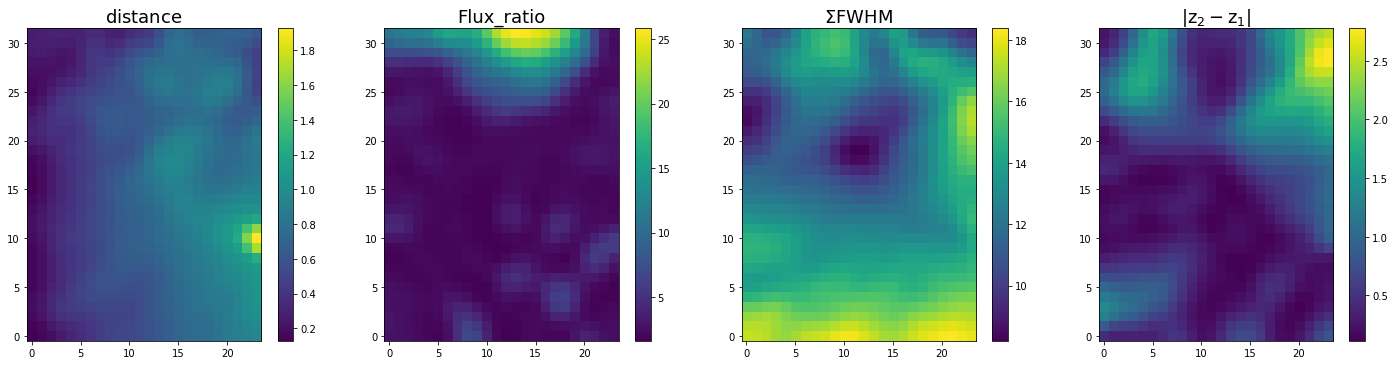

In [34]:
somcol=np.zeros(4,object)
plt.figure(figsize=(20,5))
colors=[r'$\rm distance$','Flux_ratio',r'$\rm \Sigma FWHM$',r'$\rm |z_{2}-z_{1}|$']

codebook = sm._normalizer.denormalize_by(sm.data_raw,sm.codebook.matrix)    
for ind in range(0,4):
    mp = codebook[:, ind].reshape(sm.codebook.mapsize[0],sm.codebook.mapsize[1])
    plt.subplot(1,4,ind+1)
    ax = plt.gca()
    im=ax.imshow(mp,origin='lower')
    somcol[ind]=np.ndarray.flatten(mp)
    #ax.axis('off')
    plt.title(str(colors[ind]),size=18)
    plt.colorbar(im)


plt.tight_layout()
plt.savefig('../plots/SOM_input.png')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


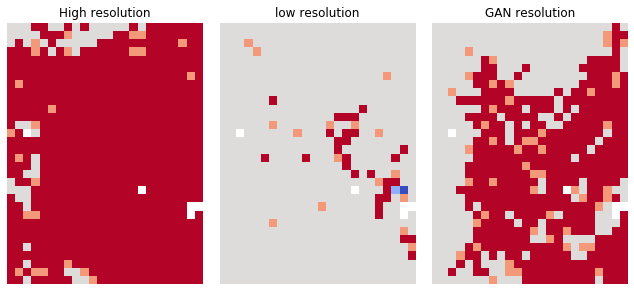

In [36]:
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
    
med_l=np.zeros([msz0,msz1])
med_g=np.zeros([msz0,msz1])
med_h=np.zeros([msz0,msz1])

low = df['numlow'][sel]
gan = df['numgan'][sel]
hi = df['numhi'][sel]
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_l[i,j]=(np.median(low[unja]))
        med_g[i,j]=(np.median(gan[unja]))
        med_h[i,j]=(np.median(hi[unja]))
        

plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.imshow(med_h,vmin=0,vmax=2,origin='lower',cmap='coolwarm')
plt.title('High resolution')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('low resolution')
plt.imshow(med_l,vmin=0,vmax=2,origin='lower',cmap='coolwarm')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('GAN resolution')
plt.imshow(med_g,vmin=0,vmax=2,origin='lower',cmap='coolwarm')
plt.axis('off')
plt.tight_layout()

#plt.savefig('../plots/SOM_blending.png')